# What can we learn from twitter data? 

Often in Data Science we find ourselves asking open ended questions as part of our analysis, and a big part of finding successful results is starting with an idea - and changing your analysis once you hit a dead end based on the data, or if you think of a better way to do it. This notebook will demonstrate this process by using sentiment analysis on Twitter data, and showing how by changing our initial idea with a different methodology (in our case: topic modeling), you can find interesting results!

## Disclaimer
As we are working with uncensored tweets captured indiscriminately from Calgary, there is a possibility that this notebook may display content that is offensive or vulgar. These tweets do not represent the views of Cybera or its employees. This dataset is simply meant to be an activity in working with text-based data, and some possible analysis surrounding it.  

## Twitter Data

By now we have developed a familiarity with our Twitter data. At this point, we might be wondering what kind of questions we can answer or insights we can gain from this data. An exciting first choice is to ask ourselves something that we may all think of as familiar: how are we feeling today? But rather than asking _ourselves_ that question, we will extract that data from our Twitter data set. This is known as **Sentiment Analysis**.


Notice periodic behaviour

TODO: Clean plot/visualize it differently to show when the most popular tweeting hours/days are. Topic/Sentiment analysis on those days??? 

## Importing the Data

As we've done before, we are going to import our data and adjust the time stamp. This time however, we are going to try and understand _when_ people are tweeting within Calgary .

In [1]:
# The modules we'll need
!pip install --upgrade pandas --user
import pandas as pd
import urllib.request
import pandas as pd 
import matplotlib.pyplot as plt
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import nltk
from IPython.display import HTML
%matplotlib inline

# This little trick is to selectively hide code in our notebook

def hide_me():
    return HTML('''<script>
    code_show=true; 
    function code_toggle() {
        if (code_show){
            $('div.cell.code_cell.rendered.selected div.input').hide();
        } else {
            $('div.cell.code_cell.rendered.selected div.input').show();
        }
        code_show = !code_show
    } 

    $( document ).ready(code_toggle);
    </script>

    To show/hide the above code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
target_url="https://swift-yeg.cloud.cybera.ca:8080/v1/AUTH_233e84cd313945c992b4b585f7b9125d/geeky-summit/tweets_cleaned.csv"
file_name="tweets_cleaned.csv"
urllib.request.urlretrieve(target_url, file_name)

df = pd.read_csv(file_name,parse_dates=['created_at_date']) 
# Convert to mountain standard time 
df.created_at_date= df.created_at_date.dt.tz_localize('UTC').dt.tz_convert('MST')



## Sentiment Analysis

Sentiment analysis easy for a human to do. It's quite simple to distinguish a sentence that is positive, negative, or neutral simply by reading it. Of course, how do we get a computer to do it for us? There are in fact several ways to do this such as training a neural network to classify our data. Unfortunately, we don't have that luxury! Luckily however, there are also libraries that assign a score, positive or negative, to certain words and characters. These libraries are called **lexicons** and each lexicon will score an individual word as positive or negative, and words that aren't within the lexicon will have a score of zero. 

### VADER

The lexicon we will be using is called VADER (Valence Aware Dictionary and sEntiment Reasoner), and you can read more about it [here](http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf) and [here](https://github.com/cjhutto/vaderSentiment). However, for us VADER is the "most ideal" sentiment lexicon as it also encodes sentiment for emojis and different levels of capitalization: something that we'll likely see a lot of on Twitter. Let's take a look at what VADER does below 

In [3]:
try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
except ModuleNotFoundError:
    !pip install vaderSentiment --user
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    print("If you see this message, please select Kernel -> Restart and run all from the top menu")
analyser = SentimentIntensityAnalyzer()

sentence = "I love eating pasta" 

print(analyser.polarity_scores(sentence))

{'neg': 0.0, 'neu': 0.323, 'pos': 0.677, 'compound': 0.6369}


Where VADER returns a score for negative language `neg`, a score for neutral language `neu`, a score for positive language `pos`, and a summary score `compound`. Where in this case we see that the sentence `I love eating pasta` is predominantly positive in nature. 

One of the nice things about VADER is that it will also assume that text in capitals is either more positive or negative. For example, if we "LOVE pasta", it is more positive that in we simply "love pasta", as seen below. 

In [4]:
sentence = "I LOVE eating pasta" 

print(analyser.polarity_scores(sentence))

{'neg': 0.0, 'neu': 0.288, 'pos': 0.712, 'compound': 0.7125}


And if we add emojis to this, those emojis are also scored!

In [5]:
sentence = "I LOVE eating pasta :)" 

print(analyser.polarity_scores(sentence))

{'neg': 0.0, 'neu': 0.201, 'pos': 0.799, 'compound': 0.8374}


As well, negative sentiments behave as you'd expect 

In [6]:
print(analyser.polarity_scores("I hate pasta"))
print(analyser.polarity_scores("I HATE pasta"))
print(analyser.polarity_scores("I HATE pasta >:("))
     

{'neg': 0.787, 'neu': 0.213, 'pos': 0.0, 'compound': -0.5719}
{'neg': 0.816, 'neu': 0.184, 'pos': 0.0, 'compound': -0.6633}
{'neg': 0.891, 'neu': 0.109, 'pos': 0.0, 'compound': -0.8455}


However, we should be aware that VADER will not recognize positive or negative words as they may appear on twitter:

In [7]:
print(analyser.polarity_scores("I LOVE pasta"))
print(analyser.polarity_scores("I #LOVE pasta"))

{'neg': 0.0, 'neu': 0.169, 'pos': 0.831, 'compound': 0.7125}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


Hence the importance of cleaning your data! That said, as hashtags can also be misleading in terms of what appears at the end of tweets, we will focus our analysis on _only_ the text bodies; we will ignore all hashtags and `@` user mentions. 

### When are people Tweeting in Calgary

Before we begin our sentiment analysis, it is always a good idea to understand _when_ people are tweeting as time can be an important factor in sentiment analysis (for example, before lunch or dinner one might see some "hanger" effects in the tweets!). In this case, let's take a quick look at the time distribution histogram of tweets. 

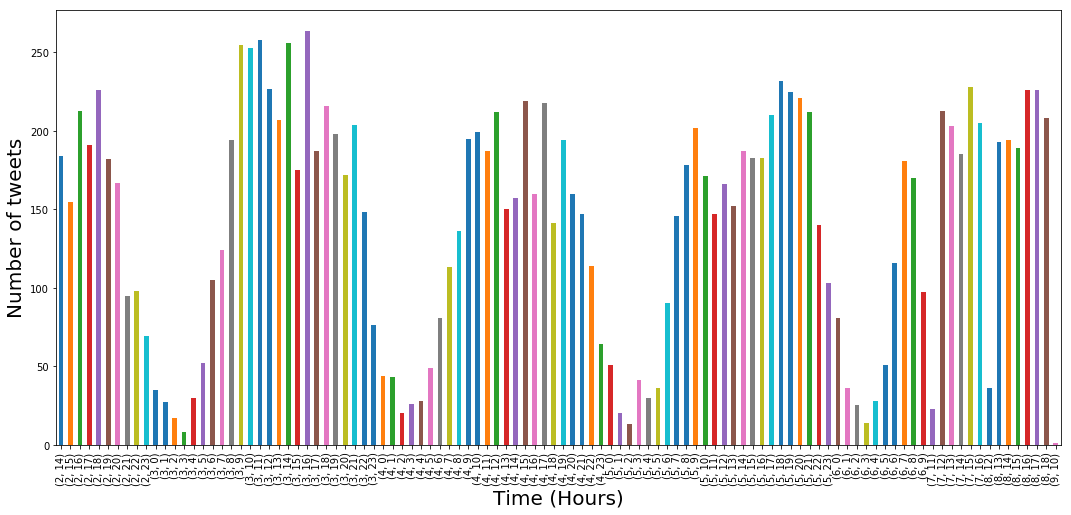

In [8]:

ax = df['created_at_date'].groupby([
            df.created_at_date.dt.day, 
            df.created_at_date.dt.hour
    ]).count().plot(kind="bar",
                    figsize = (18,8))

ax.set_xlabel("Time (Hours)", size = 20)
ax.set_ylabel("Number of tweets", size=20)
plt.show()

# This little trick is to selectively hide code in our notebook

hide_me()

Unsurprisingly, we see that there is a periodic behavior in terms of when tweets are... tweeted. In this case we see a daily lull starting from around 22:00 until 6:00, or the times when people are typically sleeping and not thinking about writing tweets. 

### Scoring the Sentiment of Twitter Data

Now that we have a basic understanding of how VADER works, calculating the sentiment of all our tweets is quite straightforward. In our case, we are only interested in the compound sentiment of the tweets. 

In [9]:
def compoundSentiment(row):
    # Notice here how we're calling explicitly the extended_tweet_cleaned
    # entry 
    score = analyser.polarity_scores(row.extended_tweet_cleaned)
    return score['compound']

# Here we use the 'apply' function to apply a function to our data frame
# axis=1 means to apply this function row-by-row

df['score'] = df.apply(compoundSentiment, axis=1)

df.head()

,created_at_date,hashtags_string,user_string,user_location,longitude,latitude,name,screen_name,extended_tweet,extended_tweet_cleaned,score
0,2018-11-02 14:01:56-07:00,,Symin16,Toronto ✈ Calgary,NaN,NaN,♠,jessmayumba85,@Symin16 I’d like to know who,I’d like to know who,0.3612
1,2018-11-02 14:02:01-07:00,,TwoCanSamAdams,YYC,NaN,NaN,hannahrae cuddleslug,thimblewad,@TwoCanSamAdams Legit. There are still chunks ...,Legit. There are still chunks in the sink an...,-0.2263
2,2018-11-02 14:02:05-07:00,job Calgary SupplyChain Hiring CareerArc,,Calgary,51.004583,-114.007914,TMJ - CAL Manuf Jobs,tmj_cal_manuf,Can you recommend anyone for this #job in #Cal...,"Can you recommend anyone for this in , AB? ...",0.3612
3,2018-11-02 14:02:10-07:00,,,🌎📱,NaN,NaN,Sunny Rai,TheSunsRay,Kids See Ghosts: love this track,Kids See Ghosts: love this track,0.6369
4,2018-11-02 14:02:13-07:00,Calgary job,,Calgary,50.997882,-114.074005,TMJ-CAL Retail Jobs,tmj_cal_retail,"See our latest #Calgary, AB #job and click to ...","See our latest , AB and click to apply: bar...",0.0000


Where we'll notice on the far left of our data frame, we now have a column called `score` with all our sentiment scores from the text. One important thing to note is that if a tweet does not have a word contained with in the lexicon for scoring, the sentiment score is zero. 

### Sentiment as a function of time

A natural first question with this data to ask is "Does how positively or negatively people are talking change throughout the day?". This could be a interesting question for a few reasons, the most predominant being is that it could be used to detect current events. If there is suddenly an influx of very positive or very negative tweets, that could indicate that there is an important event happening. Let's see how the sentiment of tweets changes per-hour in this data set. In order to do that, we have to group our data by time first, and then create a boxplot so that we may get some indication of how the data is distributed. 

### Brief note on box plots

Boxplots are an excellent way to summarize statistical data as they readily display how the data is distributed - giving you a better idea as to the range, and more importantly, the distinguishability of your data. However if you've never seen one before, here's a few important things to note about boxplots and what everything they display means. To begin, here is a labeled boxplot

![alt-text](https://cdn-images-1.medium.com/max/800/1*2c21SkzJMf3frPXPAR_gZA.png)

What we see here is a few important pieces 
1. The 'box' itself is centered on the median of the data, and has width equal to the interquartile range, or in discrete data this box contains 50% of all points. 
2. The lines that extend out are known as "whiskers" and extend from the bottom of the box, to a distance equal to 1.5 times the width of the box on each side (the inter quartile range)
3. Finally, any points outside of the whiskers are drawn individually 

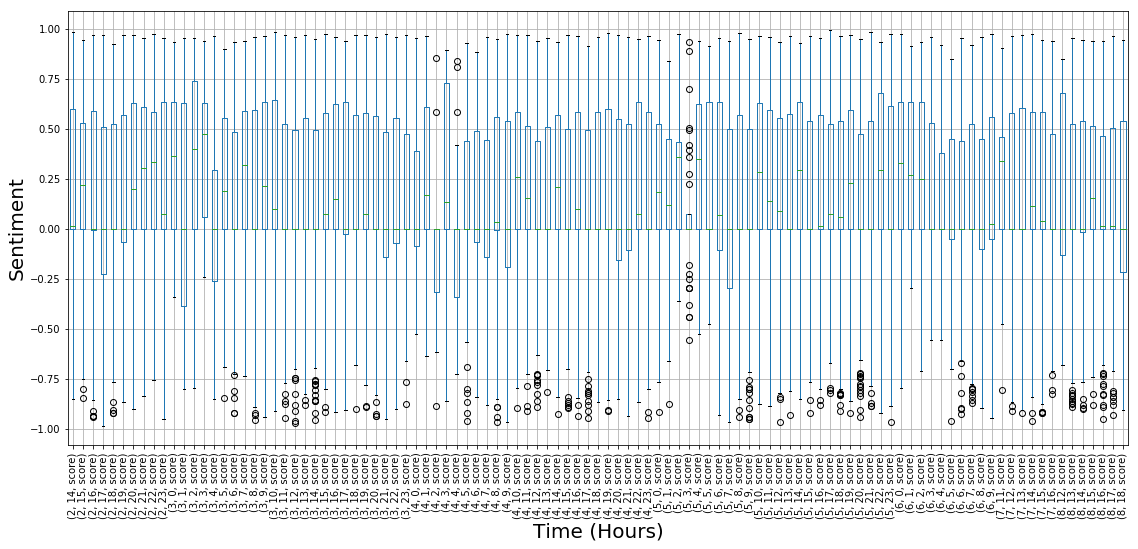

In [10]:
s_df = df.drop_duplicates(subset='extended_tweet_cleaned', keep="last").copy()
# s_df = s_df[s_df.score !=0]
s_df = s_df[s_df.created_at_date.dt.day !=9]


median = s_df[['score', 
             'created_at_date']].groupby(
                            by=[
                                s_df.created_at_date.dt.day, 
                                s_df.created_at_date.dt.hour])

ax = median.boxplot(subplots=False,
                             figsize = (19,8),
                             rot = 90,
                            )

ax.set_xlabel("Time (Hours)", size = 20)
ax.set_ylabel("Sentiment", size = 20)
plt.show()

Where in the plot above, we don't see a lot of variation. That's not very exciting. However, there is a reason for that! But... 

### Exercise 

There is a way to see some more variation! Add a single line of code to the cell above to filter out some data so that we can actually see that variation.

**Hint** Remember that if there are no words in the VADER lexicon within a tweet, it returns a sentiment score in `s_df['score']` as zero. 


### Distinguishability of data 

Once you've filtered the tweets down appropriately to see some minor variations within the data, you may notice what look like interesting variations in the size of the boxes! Unfortunately however, we also have to keep in mind our _time distribution_ that we created earlier. In almost all cases, our significantly different sentiment takes place during times where we have scored significantly fewer tweets - our results are biased due to a lack of data. 

Not to worry however! This is not unexpected. As we've aggregated about 14000 tweets from Calgary over a few days, we're simply seeing aggregate scores about how people are writing about numerous topics every day. Which brings us to an interesting question: Can we isolate those topics, and how to people feel about them? 

## Topic Analysis 

Topic analysis is an exciting technique that allows you to cluster documents/sentences or in our case, tweets, into groups of text around a similar topic as well as calculate key words in that topic. There are numerous algorithms and methods  for this task, however what we'll focus on is Latent Dirichlet Allocation (LDA). The name is a result of inferring the topics (Latent) from a multi-variate Dirichlet distribution, and they are allocated (sorted) from that distribution. That's a lot to digest, and _understanding_ how it works in general is not required in order to _use_ LDA analysis. That said, understanding it will certainly make any models more effective!

### LDA: The Basics

At a high level, at a high level what LDA does is it converts words/documents into a linear algebra and statistics problem, and then uses this conversion to cluster your documents, where each cluster represents a topic.  To understand this at a high level, we must first go through a few definitions

### Definitions

##### Corpus
A corpus refers to all the unique words contained in your text. In our case, this corpus consists of all the words within our tweets. 

##### Word Vectors

A word vector is the conversion of a word into a sparse 'one-hot' vector. What this means is that each word contained within all your texts is mapped to a unique vector. For example, the word "karate" may appear as 

\begin{equation}
\mbox{Karate} = 
\begin{pmatrix}
0 \\
\vdots \\
1 \\
\vdots \\
0
\end{pmatrix}
\end{equation}

Where it is represented as a _unique_ and _sparse_ vector that contains a single non-zero entry. The size of each word vector is the same, and is the size of our corpus. 

##### Document Vectors

A document vector is simply the word vector representation of a document/sentence or in our case, a tweet. For example, the sentence
``` 
wax on, wax off
```

is simply the vector sum of our word vectors for each word
\begin{equation}
\vec{D}_1 = \vec{w}_1 + \vec{w}_2 + \vec{w}_1 + \vec{w_3}
\end{equation}


##### Corpus (round two) 

Now that we've defined word and document vectors, our corpus is defined as our entire set of documents, or

\begin{equation}
C = \{\vec{D}_1, \vec{D}_2, ..., \vec{D}_N\}
\end{equation} 
where $N$ is the total number of documents, in our case the total number of tweets. 

# FINISH THIS ALEX 

## The Analysis

Due to the nature of Twitter, and the likely hood of their being _many_ topics that are different from day to day, we're just going to focus on the day which had the most tweets, in that case Tuesday. Below we simply create a new data frame that just contains the Tuesday data

In [11]:
subset = df[df.created_at_date.dt.day ==3]
# Road incident and dead animal clean up reporting, remove it for the
# sake of speeding up any topic modeling. Feel free to put this back in if you'd like
subset = subset[subset.screen_name != '311calgary'] 
subset = subset.reset_index()
print("Total tweets =", len(subset))
subset.head()

Total tweets = 3592


,index,created_at_date,hashtags_string,user_string,user_location,longitude,latitude,name,screen_name,extended_tweet,extended_tweet_cleaned,score
0,1580,2018-11-03 00:00:10-07:00,,LFCTransferRoom,Canada,NaN,NaN,Captain Fantastic8,nattyroons,@LFCTransferRoom So what was Shaqiri's time🤔,So what was Shaqiri's time🤔,0.0000
1,1581,2018-11-03 00:01:18-07:00,ableg,realmarkwells,Calgary,NaN,NaN,Jeff Callaway,JeffCallaway,@realmarkwells NDP posturing #ableg,NDP posturing,0.0000
2,1582,2018-11-03 00:02:26-07:00,,GoaleeMurph kasim_a29 GalvanisdHockey,"Calgary, AB, Canada",NaN,NaN,FHumpires.com,fhumpires,@GoaleeMurph @kasim_a29 @GalvanisdHockey Glad ...,Glad I specified which keeper then witho...,0.4588
3,1583,2018-11-03 00:02:51-07:00,,,Calgary Alberta Canada,51.045,-114.057,Jennifer Park,naturaliconyyc,Sun worship💜💜💜. November is upon us. Not my fa...,Sun worship💜💜💜. November is upon us. Not my fa...,-0.3412
4,1584,2018-11-03 00:05:13-07:00,ATPZORRO LOVEYYC,ATPlive,"Calgary, AB",NaN,NaN,Alex Wihak,WihakAlex,@ATPlive I know it’s not a meme but how I feel...,I know it’s not a meme but how I feel someti...,0.0000


Where we're now going to be dealing with approximately 3600 tweets in total to run our topic model. 

## Tokenizing the Corpus
However, we're not done yet! We have to clean these tweets up even more and do some processing first. To begin, we have to turn our tweets into tokens, which taking our sentence, removing punctuation, and turning it into a list. As an example, let's see the results of changing the sentence below. 

In [12]:
sentence = "I certainly, absolutely, positively, LOVE! text processing? And the number 10"
print("tokenized sentence:", gensim.utils.simple_preprocess(sentence, min_len=3))

tokenized sentence: ['certainly', 'absolutely', 'positively', 'love', 'text', 'processing', 'and', 'the', 'number']


Where we see that we've removed all the punctuation, numbers, as well as words with fewer than three characters. We've removed punctuation as they don't (typically) add much in terms of the _topic_ or _context_ in a sentence. And we've also removed words of shorter than three characters as they also typically don't add anything meaningful to the text in terms of changing the topic. 

After tokenization, a way to shorten your corpus is to remove superfluous conjugation of words, in our case _all_ conjugation. The idea being that conjugation certainly makes text easier to read, the differences in _meaning_ between differently conjugated words is minimal. In this case, we will use a process known as stemming which reduces words back to their root word. Let's see how that looks using the tokens we made above. 

In [13]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokens = gensim.utils.simple_preprocess(sentence, min_len=3)
for word in tokens:
    print(stemmer.stem(word))

certainli
absolut
posit
love
text
process
and
the
number


Notice how the "end" of each word has been truncated and occasionally replaced with `i`. This allows us to reduce the size of our corpus by reducing all possible conjugations to a single word. This will both speed up our model, and (potentially) help with the topic analysis. We will now tokenize and stem all our texts as seen below. We note that stemming is optional, and we will compare the results of a model that has been stemmed and a model that was not later. 

Finally, we will remove all stop words from the corpus, as well as add the word "amp" to stop words (as it represents an ampersand). Below is the list of stop words we shall remove. 

In [14]:
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
stop_words.append('amp')
stop_words = set(stop_words)
print(stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alextennant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
{'from', 'once', 'don', 'what', 'not', "she's", 'out', 'but', 'his', "wouldn't", 'same', "aren't", 'and', 'can', 'yourselves', 'him', 'themselves', 'which', 'them', 'i', 'how', 'why', 'now', 'was', 'each', 'itself', 'their', 'hadn', 'no', 'the', 'didn', "you've", 'wasn', 'doing', 'does', 'against', "weren't", 'whom', 'on', 'yours', "hadn't", 'it', 'further', 'ours', "you'll", "didn't", 'were', 'to', 'wouldn', 'been', 'all', 'some', 'between', 'having', "shouldn't", "isn't", 'then', 'will', 'over', 'both', 'our', 'that', "you're", 'am', 'hasn', "shan't", 'before', "wasn't", 'about', 'here', 'yourself', 'do', 'we', 'most', 'nor', 'o', 'mustn', 'or', 'hers', 'had', 'other', 'its', "mustn't", 'more', 'll', 'needn', 'y', 'won', "you'd", 'did', 'through', 'your', 'for', 'an', 'shouldn', 'theirs', 'such', 'couldn', 'm', 'any', 's', "should've", 'a

In [15]:
# Clean and tokenize 
def sent_to_words(row):
    sentence = row.extended_tweet_cleaned
    return(gensim.utils.simple_preprocess(sentence,min_len=3))  

subset['tokens'] = subset.apply(sent_to_words, axis=1)


In [16]:
# Function for stemming 
def stem(word):
    return stemmer.stem(word)
# Wrapper function to clean all the text at once 
def tokens_to_lda(row):
    data_token = row.tokens
    tokens = [token for token in data_token if token not in stop_words]
    tokens = [stem(token) for token in tokens]
    return tokens
    
subset['lemma'] = subset.apply(tokens_to_lda, axis=1)
subset = subset[subset['lemma'].apply(lambda x: len(x) > 3)]

subset.head()

,index,created_at_date,hashtags_string,user_string,user_location,longitude,latitude,name,screen_name,extended_tweet,extended_tweet_cleaned,score,tokens,lemma
2,1582,2018-11-03 00:02:26-07:00,,GoaleeMurph kasim_a29 GalvanisdHockey,"Calgary, AB, Canada",NaN,NaN,FHumpires.com,fhumpires,@GoaleeMurph @kasim_a29 @GalvanisdHockey Glad ...,Glad I specified which keeper then witho...,0.4588,"[glad, specified, which, keeper, then, without...","[glad, specifi, keeper, without, refer, dimens..."
3,1583,2018-11-03 00:02:51-07:00,,,Calgary Alberta Canada,51.045,-114.057,Jennifer Park,naturaliconyyc,Sun worship💜💜💜. November is upon us. Not my fa...,Sun worship💜💜💜. November is upon us. Not my fa...,-0.3412,"[sun, worship, november, upon, not, fave, mont...","[sun, worship, novemb, upon, fave, month, scro..."
4,1584,2018-11-03 00:05:13-07:00,ATPZORRO LOVEYYC,ATPlive,"Calgary, AB",NaN,NaN,Alex Wihak,WihakAlex,@ATPlive I know it’s not a meme but how I feel...,I know it’s not a meme but how I feel someti...,0.0000,"[know, not, meme, but, how, feel, sometimes, f...","[know, meme, feel, sometim, father]"
5,1585,2018-11-03 00:06:07-07:00,,,NaN,NaN,NaN,Pikachu THEATHEIST,AnomAtheist17,This video by Creationist Cat is fucking aweso...,This video by Creationist Cat is fucking aweso...,0.7346,"[this, video, creationist, cat, fucking, awesome]","[video, creationist, cat, fuck, awesom]"
8,1588,2018-11-03 00:12:05-07:00,,,Canada,NaN,NaN,Captain Fantastic8,nattyroons,What time is our game today..My LFC Family😎,What time is our game today..My LFC Family😎,0.0000,"[what, time, our, game, today, lfc, family]","[time, game, today, lfc, famili]"


### Final Preparations For LDA

Finally, we need to prepare our dictionary as well and a corpus for our LDA routines. In our case we will be using  `gensim` text mining module, which is opensource with documentation [here](https://radimrehurek.com/gensim/index.html). Our first step is to use their pre-packaged routines to create our word and document vectors which is done below. 

In [17]:
# Prep for the corpus 
dictionary = corpora.Dictionary(subset['lemma'])
corpus = [dictionary.doc2bow(text) for text in subset['lemma']]

print(list(dictionary)[1:10])
print(list(corpus)[2000])

[1, 2, 3, 4, 5, 6, 7, 8, 9]
[(58, 1), (131, 1), (211, 1), (804, 1), (936, 1), (1107, 1), (1314, 1), (1317, 1), (1319, 1), (1479, 1), (1776, 1)]


In the above output, the first list from dictionary is simply the "word vectors" or: where the non zero term in our encoding is. The second list contains two things, the word vector and the second number is the document ID. We of course, have just one, the entirety of Tuesday's tweets. As well, our corpus is indexed by the order it sees our tweet, so in the case printed above the list 
```
[(58, 1), (131, 1), (211, 1), (804, 1), (936, 1), (1107, 1), (1314, 1), (1317, 1), (1319, 1), (1479, 1), (1776, 1)
```
is the word vector representation of the following  


In [18]:
print("Tokens: ", subset['lemma'][2000])
print("Original Tweet:", subset['extended_tweet'][2000])

Tokens:  ['enter', 'chanc', 'win', 'win', 'ticket', 'fleetwood', 'mac', 'calgari']
Original Tweet: Enter for a chance to win Win 2 Tickets To Fleetwood Mac In Calgary! at 


We will also be using an optimized version of LDA called [MALLET](http://mallet.cs.umass.edu/). However we have to download and extract the executables, which is done below. We note that this will download to your hub account, and not your local machine. 

In [19]:
# This is to download the binaries of the LDA package we will use. This only downloads them 
# onto the hub, and not to your local machine 
import os
import requests, zipfile, io
if not os.path.isdir("mallet-2.0.8"):
    r = requests.get('http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip')
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()
else:
    print("Directory exists, no need to download it again.")


Directory exists, no need to download it again.


### Choosing The Number of Topics

Finally, there's the matter of deciding on how many topics we should be looking for. One of the most consistent ways to do this is by calculating the "coherence" of the topic model. The coherence of a topic model compares the similarity of the top $N$ words from each topic, which is typically done by taking the dot product of properly normalized word _embeddings_

\begin{equation}
\hat{w}_m \cdot \hat{w}_n = [-1, 1]
\end{equation}

Where the hats one each word vector is to specify that these are _not_ the one-hot-encoded vectors we saw above, but instead these word vectors are better called "word embeddings" or the results of training a neural network on some text to discover word similarities. An inner product of zero would imply not similar words, an inner product close to one is contextually similar words, and a inner product close to -1 implies contextually opposite words. 

The coherence score is then calculated by some measure of the average of similarity between the top $N$ words in the each topic of the model. A higher coherence typically means a better topic model. 

With that in mind, what we end up doing is running the LDA analysis for several different topics and see which number of topics returns the highest coherence before either leveling off, or losing considerable coherence. For example, this is the result of running the two three code cells below (**NOTE**: If you do this yourself, you may find that your coherence graph looks considerably different! That's expected - part of LDA involves a lot of randomization and you shouldn't expect identical results between runs!) 

![alt text](coherence.png)


Where in this case the best number of topics to pick would be between 60 and 70. 

Unfortunately, this part of the analysis is very slow and we have run these next steps in advance and provided files for you. That said, the code that generated them is below for your interest. You're free to run these cells, but they may take quite a while to complete. That said, running the next two cells is _not_ necessary to follow the remainder of this notebook

##### NOTE
If you wish to run the next three cells, you'll need to "uncomment" them by highlighting all the text and pressing `CMND + /` on mac/linux or `Ctrl + /` on windows. 

In [20]:


# def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
#     # path the the methdod we will be using for LDA analysis 
#     mallet_path = 'mallet-2.0.8/bin/mallet'
#     coherence_values = []
#     model_list = []
#     for num_topics in range(start, limit, step):
#             model = gensim.models.LdaModel(corpus=corpus, 
#                                        num_topics=num_topics, 
#                                        id2word=dictionary,
#                                        iterations = 200)
#         model_list.append(model)
#         coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
#         coherence_values.append(coherencemodel.get_coherence())

#     return model_list, coherence_values

hide_me()

In [21]:


# # Can take a long time to run.
# limit=80
# start=30
# step=10

# model_list, coherence_values = compute_coherence_values(dictionary=dictionary,
#                                                         corpus=corpus, 
#                                                         texts=subset['lemma'],
#                                                         start=start,
#                                                         limit=limit, 
#                                                         step=step)



# plt.figure(figsize = (6,3))
# x = range(start, limit, step)
# plt.plot(x, coherence_values)
# plt.xlabel("Number of  Topics", size=16)
# plt.ylabel("Coherence score", size=16)
# plt.savefig('coherence.png', bbox_inches='tight')

hide_me()

In [22]:


# # This is the function that will allow us to associate a given tweet with a topic!

# def format_topics_sentences(ldamodel=model_list[len(model_list)-1], 
#                             corpus=corpus, 
#                             texts=subset['extended_tweet'],
#                             score=subset.score):
#     # Init output
#     df = pd.DataFrame()
#     # Get main topic in each document
#     for i, row in enumerate(ldamodel[corpus]):
#         # Here we grab a list of topics, and their contributions to the model
#         topics = sorted(row, key=lambda x: (x[1]), reverse=True)
        
#         # Here we're grabbing the most dominant topic, the first index of our  row
#         # topic_num is the dominant topic number, and topic_prop is the proportion
#         # of that topic in the tweet. (Low numbers are OK)
        
#         topic_num, topic_prop = topics[0] 
        
#         # Gather words important to the topic
#         wp = ldamodel.show_topic(topic_num) 
        
#         keywords = ", ".join([word for word, prop in wp])
#         # Save them to our data frame
#         df = df.append(pd.Series([int(topic_num), 
#                                   round(topic_prop ,4), 
#                                   keywords]), 
#                                   ignore_index=True)

#     df.columns = ['topic', 'percent', 'keywords']

#     # Add original text and sentiment to the data frame 
#     contents = pd.Series(texts)
#     score = pd.Series(score)
#     df = pd.concat([df, contents, score],axis=1)
    
    
#     return(df)


# df_topic_sents_keywords = format_topics_sentences(ldamodel=model_list[3], 
#                                                   corpus=corpus, 
#                                                   texts=subset['extended_tweet'].values.tolist(),
#                                                   score=subset.reset_index().score)

# # Format
# df_dominant_topic = df_topic_sents_keywords.reset_index()
# df_dominant_topic.columns = ['number', 'topic', 'percent', 'keywords', 'tweet', 'score']

# # Show
# df_dominant_topic.head(10)

hide_me()

## Downloading Pre-Chosen Models

Below we download both stemmed and unstemmed topic models with 70 topics each to compare and contrast

In [23]:
dom_topics_unstemmed = pd.read_csv("https://swift-yeg.cloud.cybera.ca:8080/v1/AUTH_233e84cd313945c992b4b585f7b9125d/geeky-summit/non-stemmed-example.csv")
dom_topics_stemmed = pd.read_csv('https://swift-yeg.cloud.cybera.ca:8080/v1/AUTH_233e84cd313945c992b4b585f7b9125d/geeky-summit/stemmed_example.csv')

## Topic distributions

The first thing we should check is to compare how topics are distributed between the two models. To do this, we will create a histogram of how many tweets appear in each topic for both the stemmed and unstemmed models 

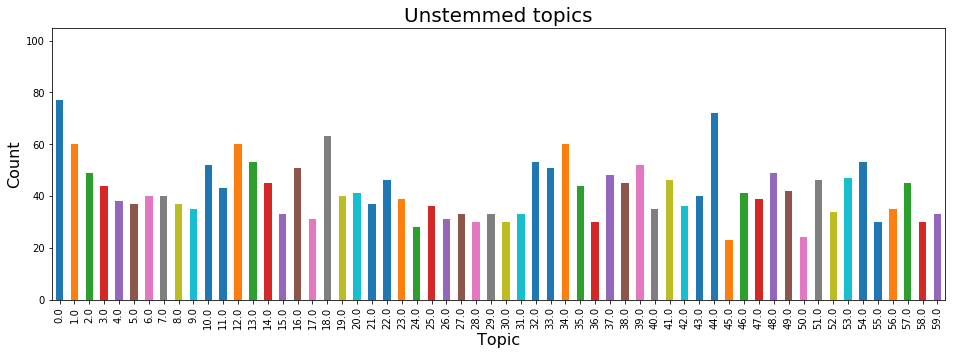

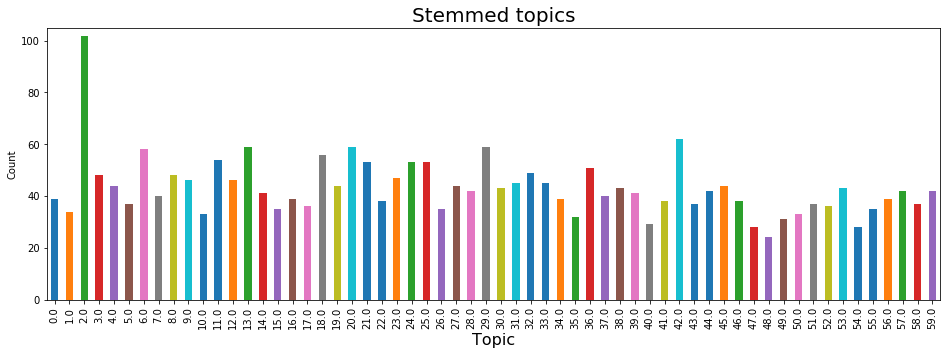

In [24]:


ax = dom_topics_unstemmed.groupby('topic')['score'].count().plot(kind='bar', figsize=(16,5))
ax.set_xlabel("Topic", size =16)
ax.set_ylabel("Count", size = 16) 
ax.set_title("Unstemmed topics", size =20)
ax.set_ylim(0,105)
plt.show()
ax2 = dom_topics_stemmed.groupby('topic')['score'].count().plot(kind='bar', figsize=(16,5))
ax2.set_xlabel("Topic", size =16)
ax2.set_ylabel("Count") 
ax2.set_title("Stemmed topics", size =20)
ax2.set_ylim(0,105)
plt.show()
hide_me()

Where this is starting to get exciting! We see that our two models have different topic distributions, but what's exciting is that our tweets are (somewhat) equally distributed - at least more so than they were in the time series. This means that our boxplot of sentiments may have more interesting results! In this case, let's create box plots of the sentiment of each topic and see if we can find any interesting results based on how positively or negatively people are tweeting about a topic. 

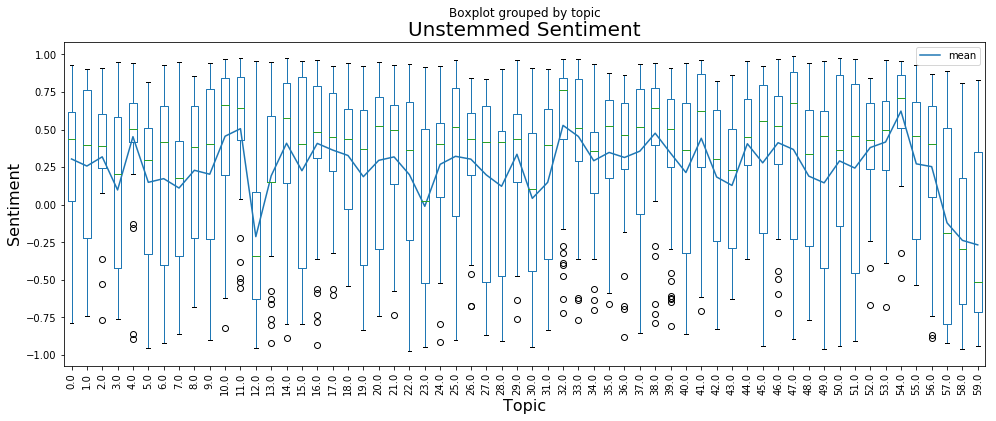

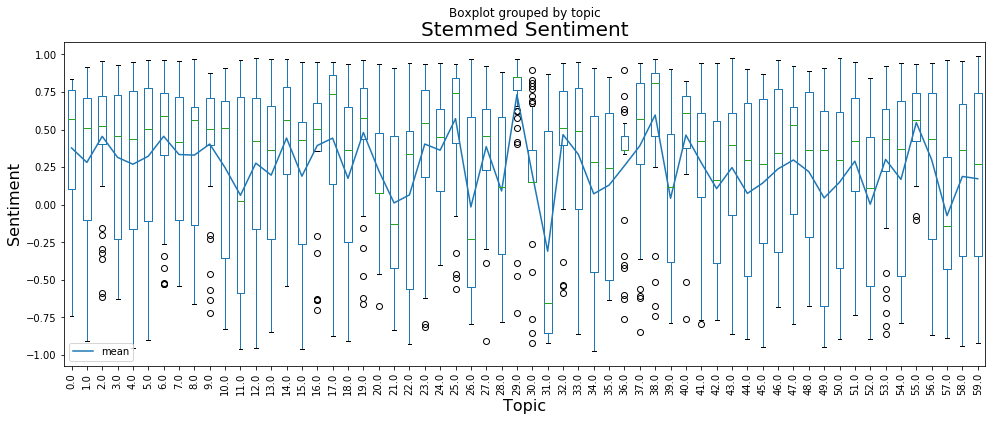

In [25]:


ax = dom_topics_unstemmed[dom_topics_unstemmed.score !=0].boxplot(figsize = (16,6), column=['score'], by='topic', rot=90)

# Weird off by one error, need to move the mean over. 
def shift(df):
    df.topic +=1
    return df

plot_df = dom_topics_unstemmed[dom_topics_unstemmed.score !=0].groupby('topic').mean().reset_index().apply(shift, axis=1).copy()

plot_df.plot(kind='line', 
            rot=90,
            y = 'score',
            ax = ax,
            x = 'topic',
            label ='mean')
ax.set_xlabel("Topic", size = 16)
ax.set_ylabel("Sentiment", size = 16)
ax.set_title("Unstemmed Sentiment", size = 20)
plt.show()

ax2 = dom_topics_stemmed[dom_topics_stemmed.score !=0].boxplot(figsize = (16,6), column=['score'], by='topic', rot=90)

plot_df = dom_topics_stemmed[dom_topics_stemmed.score !=0].groupby('topic').mean().reset_index().apply(shift, axis=1).copy()

plot_df.plot(kind='line', 
            rot=90,
            y = 'score',
            ax = ax2,
            x = 'topic', label ='mean')
ax2.set_xlabel("Topic", size = 16)
ax2.set_ylabel("Sentiment", size = 16)
ax2.set_title("Stemmed Sentiment", size = 20)
plt.show()

hide_me()

In the plots above, we have not added tweets in each topic with a sentiment of zero. But at last! Some interesting results! With our histogram from the previous graphs in mind, we see that we now have some sentiments that are not only  _distinguishable_ but we also have it in terms of different topics. With this data, we can understand how people feel about specific topics. Certainly, some topics will be more "coherent" than others.

### Explore The Data

Below we've set up a comparison between two topics that can loosely be defined as hockey. Consider how the two models compare. As well, look for outliers in the above box plots and see what each topic is about. For example is there a box with a very small spread in data points? What are people positive or negative about? A box with a very large spread in data points? What are people so polarized about? Does the sentiment scores surrounding a given topic make sense?


In [26]:
print_df = dom_topics_stemmed[dom_topics_stemmed.topic == 51].copy()
for index, text in enumerate(print_df.tweet):
    print(text, print_df.percent.iloc[index])
    print()
    print(print_df.keywords.iloc[index])
    print()
    print("*" * 60)

Wow.... I’ll fight to protect these beings until the day I die, and you should too. Nobody’s tastebuds are important enough for this to occur... Watch this video and try to prove me wrong:  0.0373

watch, night, late, song, gonna, tweet, rule, news, thought, beat

************************************************************
Late night drives to this song &gt;&gt;&gt;&gt;&gt;&gt; 0.0689

watch, night, late, song, gonna, tweet, rule, news, thought, beat

************************************************************
Saw this tweet and it made me wonder how @_LaineyBoggs_ is doing? 0.0267

watch, night, late, song, gonna, tweet, rule, news, thought, beat

************************************************************
“What have you done for me lately” #Unfair in my opinion or is there something behind it. 0.0346

watch, night, late, song, gonna, tweet, rule, news, thought, beat

************************************************************
@artofmmignola Hard to beat HB and well deserved. 0.03

In [27]:
print_df = dom_topics_unstemmed[dom_topics_unstemmed.topic == 12].copy()
for index, text in enumerate(print_df.tweet):
    print(text, print_df.percent.iloc[index])
    print()
    print(print_df.keywords.iloc[index])
    print()
    print("*" * 60)

@ElkeBabiuk @ColeslamTalia "Psychological warfare, according to Paul Linebarger, is a continuous process not controlled by laws, usages &amp; customs of war — covert, often disguised as the voice of institutions &amp; media — a non-violent persuasion waged before, during, and after war."  0.0681

world, fire, shot, party, war, penalty, woman, speak, question, puck

************************************************************
time to scrap all the timezones around the world.... just have one clock time for all..... 0.0327

world, fire, shot, party, war, penalty, woman, speak, question, puck

************************************************************
Game Day !!! 🔥🔥🔥 vs Red Deer Chiefs 📍: MaxBell  ⏰ :1115 🖥 : Calgary Fire YouTube  @calgaryfireAAA @rdsfaaachiefs  0.048

world, fire, shot, party, war, penalty, woman, speak, question, puck

************************************************************
@BorisEP Actually, racist trash fire is pretty accurate. But, I don’t know who Chris is .

## What is each topic about?

One important fact about topic analysis is that it automatically sorts your text, but you still have no idea what each topic is about! One of the easiest ways to figure out what each topic is about is by looking at the keywords for each topic. Below we've printed the first five, feel free to add an argument (or remove) to the `.head()` function below to print more of the topics to try and see if there's a topic you find interesting to explore more! 

In [28]:
dom_topics_unstemmed.drop_duplicates(subset='topic')[['topic', 'keywords']].head()

,topic,keywords
0,11.0,"book, food, awesome, person, ready, local, swe..."
1,19.0,"month, bad, order, comment, answer, lol, poten..."
2,3.0,"watching, son, power, score, movie, run, leagu..."
3,38.0,"happy, kid, birthday, phone, girl, cat, cut, t..."
4,0.0,"game, tonight, move, action, calling, remember..."


In [29]:
dom_topics_stemmed.drop_duplicates(subset='topic')[['topic', 'keywords']].head()

,topic,keywords
0,27.0,"today, place, seat, hockey, special, row, toge..."
1,36.0,"photo, anyon, post, head, made, recommend, man..."
2,23.0,"anoth, yeah, secur, bad, creat, tonight, budge..."
3,42.0,"goal, minut, shot, video, period, score, half,..."
5,37.0,"realli, idea, school, record, listen, super, s..."


# Conclusion

Here we've given a practical introduction to LDA analysis and sentiment analysis with python. More importantly however, we've demonstrated how you can extract interesting results when the initial data analysis didn't show anything promising. In our case, our initial time series and sentiment didn't really reveal anything fascinating, and we needed to do something more exciting in order to glean useful information from our twitter data. And at the end of the day, that's what Data Science is all about - being creative in order to extract meaningful information where it may not have been initially obvious.